In [1]:
import neuralop
import numpy as np
import matplotlib.pyplot as plt


import sys
import torch

import yaml
import gc
import imp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import evaluation_metrics as em

/tmp/ipykernel_603865/712654110.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
device

device(type='cuda', index=0)

In [3]:
# list all model files
import glob 
model_files = glob.glob("/central/groups/esm/jschmitt/neuralop/ks_models/res*.pth")
config_files = glob.glob("/home/jschmitt/KS_FNO/KS/resolution_configs/resolution_*.yaml")

In [86]:
i = 64 # coarsen factor 
model = torch.load(f"/central/groups/esm/jschmitt/neuralop/ks_models/res_{i}.pth", weights_only=False) # , map_location=torch.device('cpu')
#model = torch.load(f"/central/groups/esm/jschmitt/neuralop/ks_models/pygen_full_res.pth", weights_only=False) # , map_location=torch.device('cpu')
config = yaml.safe_load(open(f"/home/jschmitt/KS_FNO/KS/resolution_configs/resolution_{i}.yaml"))

In [87]:
# load test data 
data = torch.load("/central/groups/esm/jschmitt/neuralop/pygen_200_512_2000_20_201.06.pth").to(device).to(torch.float32).permute(2, 1, 0)
data = data[:, :, 0:2] # only use first 2 observations for debugging, used for plotting comparison
data_coarse = data[::i, :, :] # coarsen data for prediction
print(data_coarse.shape)

torch.Size([8, 2000, 2])


In [88]:
predictions = torch.zeros(data_coarse.shape)

with torch.no_grad():
    for i in range(data_coarse.shape[2]):
        print("Element ", i)
        pred_i = data_coarse[:, :, i].clone().to(device)
        
        for j in range(500, 1999):
            pred_i[:, j+1] = model(pred_i[:, j].unsqueeze(0).unsqueeze(0)).detach()

        predictions[:, :, i] = pred_i.cpu()#.unsqueeze(2)


Element  0
Element  1


In [89]:
i = 64

(8, 2000)
(2000,)
0
(512, 2000, 2)
(8, 2000, 2)
Histogram Kolmogorov-Smirnov Error: 0.14, p-value: 3.2e-120
Max Error in Spectrum: 2.8e+30 at frequency 0


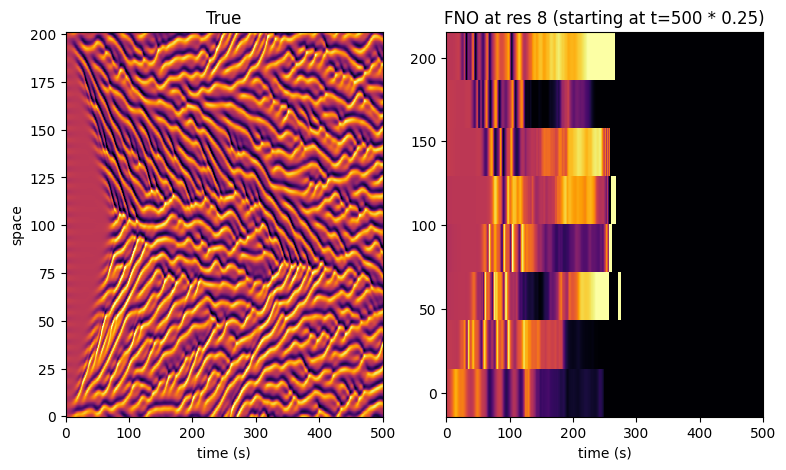

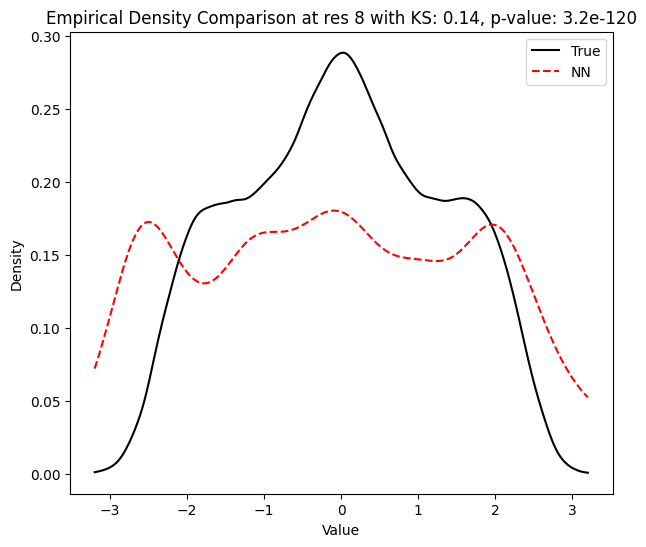

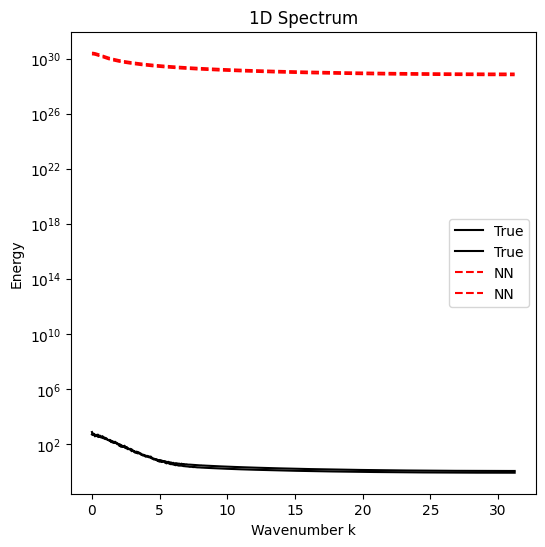

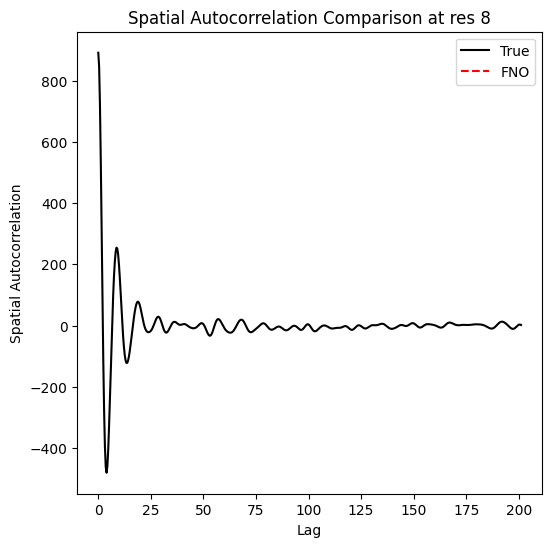

In [90]:
import imp 
imp.reload(em)
em.evaluate_metrics(data.detach().cpu().numpy(), predictions.detach().cpu().numpy(), config, f"res_{i}")